In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import contractions
from sklearn.model_selection import StratifiedShuffleSplit
from time import time

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.utils import compute_sample_weight



# Import Regex to clean up comments
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

from sklearn.metrics import precision_score, recall_score, f1_score


from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint





from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import random


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antoine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Préparation des données 

## Importer le dataset

In [213]:
data = pd.read_csv('./datasets/train.csv')
data.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Split des données

#### On souhaite crée un nouveau dataset plus petit pour pouvoir entrainer et tester nos modèles plus rapidement

Pour se faire, on va utiliser l'outil StratifiedShuffleSplit

Celui-ci permet de créer un sous dataset ayant les mêmes proportions pour chaque label tout en prenant des données en mode aléatoire.

Cet outil marche pour les classification binaire et catégoriques mais nous allons l'adapter pour l'utiliser sur de la classification multilabel

In [214]:
# Toutes les catégories de commentaires
categories = ['identity_hate', 'toxic', 'severe_toxic', 'threat', 'insult', 'obscene']

# Créer une colonne qui concatene toutes les catégories de commentaires
data['combined'] = data[categories].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

# Affiche toutes les combinaisons existantes et leur nombre d'apparition
print(data['combined'].value_counts())

combined
000000    143346
010000      5666
010011      3800
010001      1758
010010      1215
011011       989
110011       618
000001       317
000010       301
111011       265
000011       181
011001       158
110000       136
110010       134
010111       131
010100       113
011111        64
110111        56
100000        54
011000        41
110001        35
111111        31
100010        28
000100        22
100011        18
010110        16
011010        14
010101        11
011100        11
110100         7
111010         7
111001         6
011101         4
000110         3
110110         3
111000         3
100001         3
000101         2
000111         2
011110         1
111100         1
Name: count, dtype: int64


In [215]:
# Ne pas prendre en compte les combinaisons qui n'apparaissent qu'une seule fois dans le dataset
data = data[data['combined'] != '011110']
data = data[data['combined'] != '111100']

In [216]:
# Définir la taille du sous-ensemble
n_samples = 15000

# Créer un stratifieur pour le sous-ensemble
stratifier = StratifiedShuffleSplit(n_splits=1, test_size=n_samples/len(data), random_state=0)

# Définir les indices des sous-ensembles et les prélever
for train_index, test_index in stratifier.split(data, data['combined']):
    df_test = data.iloc[test_index]
    df_train = data.iloc[train_index]

# Supprimer la colonne combinée
df_test = df_test.drop("combined", axis=1)
df_train = df_train.drop("combined", axis=1)

# Afficher les proportions dans le sous-ensemble pour verifier
for cat in categories:
    print(f"Test -- {cat}: {df_test[cat].value_counts()[1] / n_samples:.2%}")
    print(f"Train - {cat}: {df_train[cat].value_counts()[1] / len(df_train):.2%}")

Test -- identity_hate: 0.89%
Train - identity_hate: 0.88%
Test -- toxic: 9.59%
Train - toxic: 9.58%
Test -- severe_toxic: 1.00%
Train - severe_toxic: 1.00%
Test -- threat: 0.29%
Train - threat: 0.30%
Test -- insult: 4.93%
Train - insult: 4.94%
Test -- obscene: 5.29%
Train - obscene: 5.30%


## Création d'une nouvelle colonne IsToxic 

Cette colonne servira à faire de la classification binaire au lieu d'une classification multiclasse.

En effet, dans un premier temps, nous allons simplifier le problème en demandant à notre IA de savoir faire la distinction entre un commentaire toxique et un commentaire correct

In [217]:
df_test['isToxic'] = df_test.iloc[:, -6:].apply(lambda row: 1 if row.any() else 0, axis=1)

## Filtrer et nettoyer les données 

Après avoir préparer notre nouveau jeu de données, nous allons maintenant le nettoyer et le filtrer pour pouvoir simplifier l'apprentissage et pouvoir par la suite Tokenizer chaque mot en index. 

En effet, les mots "tbh" et "to be honest" ont la même signification donc on souhaitera qu'il apparaissent de la même manière.

De même les mots "of", "the" ou encore "to" sont des mots qui ne portent pas d'information sur les sentiments de la phrase. On les appele des stopwords et nous souhaitons nous en debarasser.

Pour se faire nous allons nous servir des libs NLTK et contractions ainsi que des fonctions trouvées sur Kaggle dont nous nous sommes servis pour analyser les sentiments de tweets

Setup NLTK pour tokenizer et enlever les stopwords

In [218]:
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

In [219]:
def clean(comment):

    # Lib contractions which automatically fix a lot of contractions
    contractions.fix(comment)
    
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"yrs", "years", comment)
    comment = re.sub(r"hrs", "hours", comment)
    comment = re.sub(r"2morow|2moro", "tomorrow", comment)
    comment = re.sub(r"2day", "today", comment)
    comment = re.sub(r"4got|4gotten", "forget", comment)
    comment = re.sub(r"b-day|bday", "b-day", comment)
    comment = re.sub(r"mother's", "mother", comment)
    comment = re.sub(r"mom's", "mom", comment)
    comment = re.sub(r"dad's", "dad", comment)
    comment = re.sub(r"hahah|hahaha|hahahaha", "haha", comment)
    comment = re.sub(r"lmao|lolz|rofl", "lol", comment)
    comment = re.sub(r"thanx|thnx", "thanks", comment)
    comment = re.sub(r"goood", "good", comment)
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"some1", "someone", comment)

    # Character entity references
    comment = re.sub(r"&gt;", ">", comment)
    comment = re.sub(r"&lt;", "<", comment)
    comment = re.sub(r"&amp;", "&", comment)

    # Typos, slang and informal abbreviations
    comment = re.sub(r"w/e", "whatever", comment)
    comment = re.sub(r"w/", "with", comment)
    comment = re.sub(r"<3", "love", comment)

    # Urls
    comment = re.sub(r"http\S+", "", comment)

    # Numbers
    comment = re.sub(r'[0-9]', '', comment)

    # Eliminating the mentions
    comment = re.sub("(@[A-Za-z0-9_]+)","", comment)

    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        comment = comment.replace(p, '')

    # ... and ..
    comment = comment.replace('...', ' ... ')
    if '...' not in comment:
        comment = comment.replace('..', ' ... ')


    return comment

In [220]:
def remove_stopwords(comment):
    # Tokenize
    comment_words = word_tokenize(comment)

    # Eliminating the word if its length is less than 3
    comment = [w for w in comment_words if len(w)>2]

    # remove stopwords
    comment = [w.lower() for w in comment if not w in stop_words]
    corpus.append(comment)
    
    # join back
    comment = ' '.join(comment)

    return comment

In [221]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life recomment",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "recomment",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "comment me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(comment):
    t=[]
    words=comment.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t)

In [222]:
def prepare_string(comment):
  comment = convert_abbrev_in_text(comment)
  comment = clean(comment)
  comment = remove_stopwords(comment)
  return comment

In [223]:
df_test['comment_text'] = df_test['comment_text'].replace('\n', ' ', regex=True) # Remove new lines
df_test['comment_text'] = df_test['comment_text'].replace(':', '', regex=True) # Remove colons
df_test['comment_text'] = df_test['comment_text'].str.lower() # Lowercase
df_test['comment_text'] = df_test['comment_text'].str.replace('[^\w\s]', '', regex=True) # Remove punctuation
df_test['comment_text'] = df_test['comment_text'].str.replace('\d+', '', regex=True) # Remove numbers
df_test['comment_text'] = df_test['comment_text'].str.replace(' +', ' ', regex=True) # Remove extra spaces
df_test['comment_text'] = df_test['comment_text'].str.strip() # Remove leading/trailing spaces

# Apply prepare_string to all rows in 'tweets' column
df_test['comment_text'] = df_test['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
df_test['comment_text'].replace('', np.nan, inplace=True)
df_test.dropna(subset=['comment_text'], inplace=True)

In [224]:
# add isToxic column
df_test['isToxic'] = df_test.iloc[:, -6:].apply(lambda row: 1 if row.any() else 0, axis=1)

## Exportation des données

In [225]:
df_test.to_csv('./datasets/test_filtered_data.csv')

# TFIDF & RandomForestClassifier

## Lecture du dataset cleaned

In [226]:
df = pd.read_csv('./datasets/test_filtered_data.csv')
df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,isToxic
0,21796,3971ac8df63c1b67,assistance request hello spare time wondering ...,0,0,0,0,0,0,0
1,115490,69a4e6fed52303d5,nicholas chiha born south afica japan love mid...,0,0,0,0,0,0,0
2,154633,b0d7b6c498c7af46,question garnering donations america europe so...,0,0,0,0,0,0,0
3,82818,dd941b8dd87b85b8,done alot research page started working minute...,0,0,0,0,0,0,0
4,106347,390861cc8aa889af,huh actually according wpporn issue image dele...,1,0,0,0,0,0,1


In [227]:
# Commentaires que l'on va vectoriser
comments = df['comment_text']

# labels multi-classes et binaire
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
y_binary = df['isToxic']

## Setup TFIDFVectorizer

TFIDF compare l'importance de chaque mot dans le dataset. Les mots qui apparaissent très souvent sont plus important que les autres.

TFIDF ne differencie pas les mots en fonction de leur ordre dans la phrase et ne comprends pas le contexte.

In [228]:
tfIdfVectorizer = TfidfVectorizer()
X = tfIdfVectorizer.fit_transform(comments).toarray()

## Split des données d'entrainement et de validation

In [229]:
test_portion=.15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_portion, random_state=0)
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=test_portion, random_state=0)

## RandomForestClassifier 

#### On crée 2 modeles : 
- l'un essaye de savoir si un commentaires et toxiques ou non
- l'autre essaye de trouver si un commentaires et toxiques et, si oui, de quel type 



#### RandomForestClassifier possède un argument qui nous est très utile : "class_weight='balanced'".

Celui-ci permet de donner autant d'importance a tous les labels en reequilibrant avec un coefficient toutes les données. 

En effet, dans notre dataset, nous n'avons que très peu de données toxique ce qui entraine des problèmes lors de l'entrainement puisque le modèle a tendance a donner trop peu d'importance a certaines categories.



In [230]:
text_classifier = RandomForestClassifier(n_estimators=15, random_state=0, class_weight='balanced')
history = text_classifier.fit(X_train, y_train )

text_classifier_binary = RandomForestClassifier(n_estimators=15, random_state=0, class_weight='balanced')
history_binary = text_classifier_binary.fit(X_train_binary, y_train_binary)

## Prédictions

In [231]:
predictions = text_classifier.predict(X_test)
predictions_binary = text_classifier_binary.predict(X_test_binary)

## Métriques

On crée un dataframe qui servira a contenir les métriques de tous les modèles pour comparer les performances

In [232]:
metrics_score = pd.DataFrame(columns=['model', 'roc_auc', 'confusion_matrix', 'precision_score', 'recall_score', 'f1_score'])


#### AUC_ROC
On va regarder la Area Under the Receiver Operating Characteristic Curve

Cette métrique permet de mesurer la capacité d'un modèle a dinstinguer 2 classes.

L'avantage de cette métrique est qu'elle ne prends pas en compte le seuil de classification comme la prècison et le rappel...

In [233]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = roc_curve(target, predictions)
    roc_auc = auc(fpr, tpr)
    return roc_auc

#### Précision, Rappel et F1

l'AUC_ROC ne prends pas en compte le cout different les faux positifs et faux negatifs 

Par ailleurs, dans notre cas, comme nous avons que très peu d'exemple toxiques, le modèle a tendance à donner moins d'importance aux données toxiques. Ceci entraine donc une augementation des faux négatifs.

On sait alors que l'on aura un score de rappel et de prècision assez bas et que l'on veut l'ameliorer.

Si on donne trop d'importance aux données toxiques, on se retrouvera avec beaucoup trop de faux positifs car le modele sera devenu trop sensible.

C'est pour cela que le score F1 est aussi interessant, car il prend en compte les 2 metriques precèdentes.

In [234]:

def display_binary_metrics(model, X_test, y_test, name):
    # prédictions et vraies valeurs
    y_pred = model.predict(X_test)
    y_true = y_test

    # Affichage de l'aire sous la courbe ROC
    roc = roc_auc(y_pred, y_true)
    print(f"Auc: {roc} ")

    # Arrondir les prédictions
    y_pred = y_pred.round()

    # Affichage de la matrice de confusion
    conf = confusion_matrix(y_true, y_pred)
    print(f"Matrice de confusion : {conf}")

    # Affichage de la précision
    precision = precision_score(y_true, y_pred)
    print(f"Précision : {precision}")

    # Affichage du rappel
    recall = recall_score(y_true, y_pred)
    print(f"Rappel : {recall}")

    # Affichage du score F1
    f1 = f1_score(y_true, y_pred)
    print(f"Score F1 : {f1}")

    return {
        'model': name,
        # 'accuracy_score': accuracy,
        # 'loss_score': loss,
        'roc_auc': roc,
        'confusion_matrix': conf,
        'precision_score': precision,
        'recall_score': recall,
        'f1_score': f1
    }




In [235]:
# Affichage des métriques
metrics = display_binary_metrics(text_classifier_binary, X_test_binary, y_test_binary, 'RandomForestClassifier')

# Enregistrement des metrics dans le dataframe
metrics_score = pd.concat([metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)

Auc: 0.6824885640675113 
Matrice de confusion : [[1987   15]
 [ 155   92]]
Précision : 0.8598130841121495
Rappel : 0.3724696356275304
Score F1 : 0.519774011299435


/var/folders/4h/0hgx3df95ll34vbrssxhzfvm0000gn/T/ipykernel_1135/3138119679.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_score = pd.concat([metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)


## Exportation du modèle

In [236]:
from joblib import dump

# Sauvegarder le modèle
dump(text_classifier, 'text_classifier.joblib')
dump(tfIdfVectorizer, 'tfIdfVectorizer.joblib')

['tfIdfVectorizer.joblib']

# Importation du Dataset

In [237]:
df = pd.read_csv('./datasets/test_filtered_data.csv')

In [238]:
comments = df['comment_text']
y = df['isToxic']

# Tokenizer

On convertit tous les commentaires en liste de mots.

Chaque mot est, par la suite, transformé en integer, representant l'index du mot dans un dictionnaire.

Dans notre cas, on s'assure d'enlever tous les caractères speciaux, de mettres tous les mots en minuscule et on dit au modele que s'il ne reconnait pas un mot parce que pas dans son vocabulaire, on mettra la balise "OOV" 

In [239]:
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)

# Setup the tokenizer
tokenizer = Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    oov_token=oov_tok,
)

In [240]:
# Entrainement du tokenizer sur les commentaires
tokenizer.fit_on_texts(comments)

# Convertir les commentaires en séquences après entrainement du tokenizer sur les commentaires
sequences = tokenizer.texts_to_sequences(comments)

In [241]:
# Dictionnaire des index des mots
word_index = tokenizer.word_index

# Taille du vocabulaire
vocab_size = len(word_index)

# Dimension de l'input de l'embedding
input_dimension = vocab_size + 1


## Padding

Notre modèle à une input shape qui ne peux pas etre modifié. Ainsi, on determine une taille d'entrée de chaque commentaire. 

Dans notre cas, ce sera 50 caracteres.

Si le commentaire est trop court, on remplira le commentaire avec l'index de vocabulaire 0 et si il est trop grand, on le coupe en conservant le debut de la sequence.

In [242]:
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
max_length = 50   # Maximum size of a tweet

# Padding & Truncature des sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Recurrent Neural Network en Binary Classification

On definit le nombre d'epochs et la batch_size de tous les modèles par la suite

In [243]:
epochs = 5
batch_size = 128

# Split les sequences 
on divise le jeu de donnée en données d'entrainement et de validation

In [244]:
test_portion=.15

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=test_portion)

# Sample Weight

sample_weight permet de donner autant d'importance a tous les labels en reequilibrant avec un coefficient toutes les données. 

En effet, dans notre dataset, nous n'avons que très peu de données toxique ce qui entraine des problèmes lors de l'entrainement puisque le modèle a tendance a donner trop peu d'importance a certaines categories.

les modèles hors RandomForestClassifier, ne prennent pas en compte de manière native l'utilisation de sample_weight en mode balanced. 

Toutefois, on peut retrouver un outil permettant de le faire avec sklearn : compute_sample_weight

Pour se faire il faut lui donner une listes de tous les labels associé aux données d'entrainement.






In [245]:
from sklearn.utils import compute_sample_weight

# recuperer les poids des classes de manière équilibrée en fonction des classes presentes dans y_train
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# augmentation des poids des commentaires toxiques
# sample_weights[y_train == 1] *= 1.5

# Embedding & GloVe

L'embedding permet de capturer les relatition entre les mots et de réaliser des opération mathematiques sur ces representations, grace à leur representation vectoriel dans un espace a n dimensions.

Un embedding performant est donc obligatoire si l'on veut avoir un modele performant.

Pour se faire, nous avons choisi GloVe. 

C'est une couche d'embedding préentrainé par Stanford, donc bien plus performante que n'importe quel embedding que nous entrainerons nous même.

In [246]:
embedding_dim = 300    # Dimensions used
embeddings_index = {}

# Ouverture du fichier glove
f = open('./Glove/glove.840B.300d.txt','r', encoding='utf-8')

# Lecture de chaque ligne du fichier
for line in f:
    values = line.split(' ')

    # Recuperation du mot au debut de la ligne
    word = values[0]

    # Recuperation des valeurs de vecteurs
    coefs = np.asarray([float(val) for val in values[1:]])

    # Ajout du mot et de son vecteur dans le dictionnaire
    embeddings_index[word] = coefs

# Fermeture du fichier
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 2196016 word vectors.


In [247]:
# Créer une matrice de dimension (input_dimension, embedding_dim)
embedding_matrix = np.zeros((input_dimension, embedding_dim))

# Remplir la matrice de mots avec les vecteurs de mots
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# SimpleRNN (sans GloVe)

- Dropout permet de desactiver une certaine proportion des neurones. Il est très utile pour empecher le modele d'overfit

- SpatialDropout1D est une variante de Dropout, plus performante sur les données spatiales. Cela est plus performant sur de l'embedding car il desactive aléatoirement des canaux entiers au lieu de simplement desactiver des neurones.

- BatchNormalization sert avant tout à donner de la stabilité à notre modèle et d'accelerer l'apprentissage en rendant les poids plus faciles à optimiser vu qu'il normalise

Étant donné que l'on fait une classification binaire, on choit une fonction d'activation "sigmoid" dans la couche de sortie avec un neurone.

En effet, sigmoid est interessante dans notre cas car elle peut donner un resultat interpretable comme la probabilité que la sortie du neurone soit 1.

In [248]:

model = Sequential()
model.add(Embedding(input_dim=input_dimension, output_dim=300, input_length=max_length))
model.add(SpatialDropout1D(0.3))
model.add(SimpleRNN(300))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid')) 

model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 300)           14379900  
                                                                 
 spatial_dropout1d_11 (Spat  (None, 50, 300)           0         
 ialDropout1D)                                                   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 300)               180300    
                                                                 
 dropout_18 (Dropout)        (None, 300)               0         
                                                                 
 batch_normalization_18 (Ba  (None, 300)               1200      
 tchNormalization)                                               
                                                                 
 dense_15 (Dense)            (None, 1)                

Étant donné que l'on fait une classification binaire, on choit binary_crossentropy pour la loss function, ce qui est le choix par defaut quand notre modele donne des probabilité de sortie comme fait sigmoid.

In [249]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [250]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    batch_size=batch_size
)
print("Training Complete")

Epoch 1/5


100/100 [==============================] - 9s 87ms/step - loss: 0.7870 - accuracy: 0.5292 - val_loss: 0.8093 - val_accuracy: 0.1094
Epoch 2/5
100/100 [==============================] - 9s 86ms/step - loss: 0.7630 - accuracy: 0.5322 - val_loss: 0.6418 - val_accuracy: 0.9022
Epoch 3/5
100/100 [==============================] - 9s 88ms/step - loss: 0.7852 - accuracy: 0.5168 - val_loss: 0.7304 - val_accuracy: 0.2392
Epoch 4/5
100/100 [==============================] - 9s 87ms/step - loss: 0.7323 - accuracy: 0.5293 - val_loss: 0.3661 - val_accuracy: 0.9017
Epoch 5/5
100/100 [==============================] - 9s 87ms/step - loss: 0.6995 - accuracy: 0.5163 - val_loss: 0.5909 - val_accuracy: 0.9008
Training Complete


## Courbes de Training et Validation

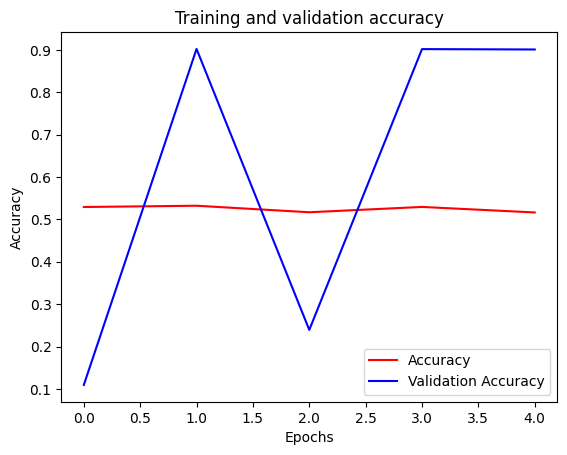

<Figure size 640x480 with 0 Axes>

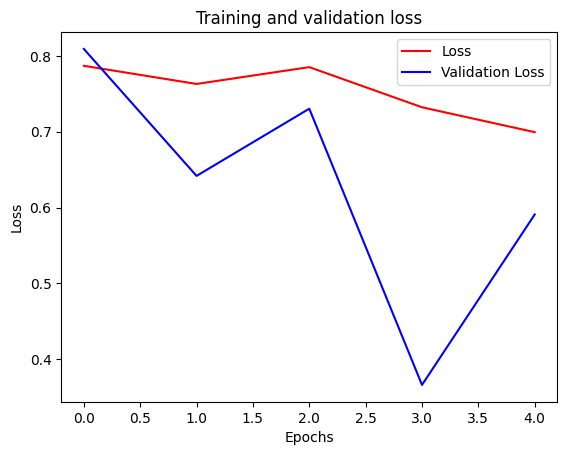

<Figure size 640x480 with 0 Axes>

In [251]:
def display_training_curves(history):
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    #-----------------------------------------------------------
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])

    plt.figure()
    plt.show()

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])

    plt.figure()
    plt.show()

display_training_curves(history)

## Métriques

In [252]:
# Affichage des métriques
metrics = display_binary_metrics(model, X_test, y_test, 'RNN (No GloVe)')

# Enregistrement des metrics dans le dataframe
metrics_score = pd.concat([metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)

71/71 [==============================] - 1s 9ms/step
Auc: 0.6419788072942336 
Matrice de confusion : [[2024    5]
 [ 218    2]]
Précision : 0.2857142857142857
Rappel : 0.00909090909090909
Score F1 : 0.017621145374449337


# SimpleRNN + GloVe

- On ajoute Ajoute gloVe à notre modèle et on ne l'entraine pas car il est deja entrainé


In [253]:
model = Sequential()
model.add(Embedding(input_dimension, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(SimpleRNN(300))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 300)           14379900  
                                                                 
 spatial_dropout1d_12 (Spat  (None, 50, 300)           0         
 ialDropout1D)                                                   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 300)               180300    
                                                                 
 dropout_19 (Dropout)        (None, 300)               0         
                                                                 
 batch_normalization_19 (Ba  (None, 300)               1200      
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 1)                

In [254]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [255]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    batch_size=batch_size
)
print("Training Complete")

Epoch 1/5


100/100 [==============================] - 6s 53ms/step - loss: 0.7593 - accuracy: 0.5463 - val_loss: 0.6551 - val_accuracy: 0.6323
Epoch 2/5
100/100 [==============================] - 5s 55ms/step - loss: 0.6973 - accuracy: 0.6271 - val_loss: 0.6175 - val_accuracy: 0.7056
Epoch 3/5
100/100 [==============================] - 6s 55ms/step - loss: 0.7397 - accuracy: 0.5831 - val_loss: 0.6427 - val_accuracy: 0.6060
Epoch 4/5
100/100 [==============================] - 5s 54ms/step - loss: 0.6327 - accuracy: 0.6822 - val_loss: 0.5206 - val_accuracy: 0.7715
Epoch 5/5
100/100 [==============================] - 6s 60ms/step - loss: 0.6053 - accuracy: 0.7045 - val_loss: 0.7373 - val_accuracy: 0.5322
Training Complete


## Courbes de Training et Validation

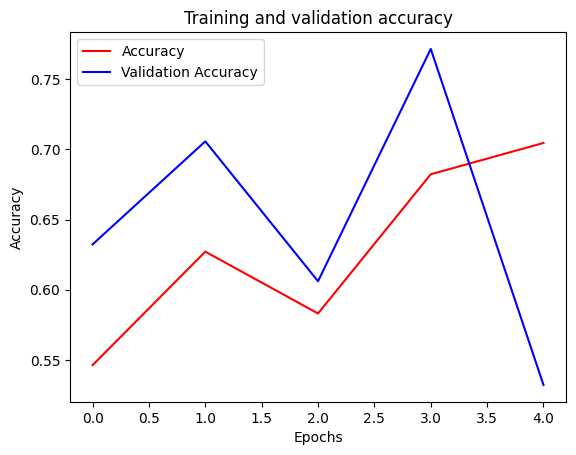

<Figure size 640x480 with 0 Axes>

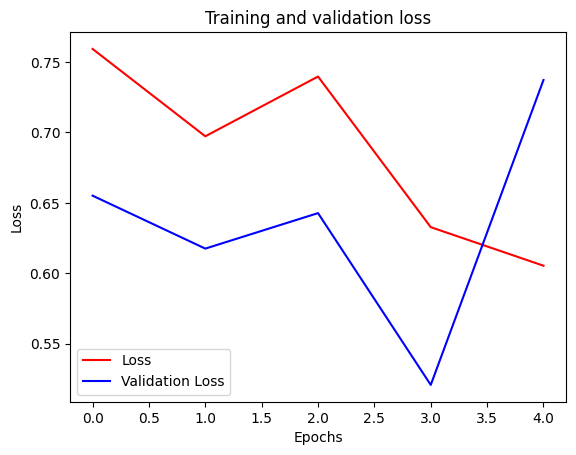

<Figure size 640x480 with 0 Axes>

In [256]:
display_training_curves(history)

## Métriques

In [257]:
# Affichage des métriques
metrics = display_binary_metrics(model, X_test, y_test, 'RNN')

# Enregistrement des metrics dans le dataframe
metrics_score = pd.concat([metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)

71/71 [==============================] - 1s 9ms/step
Auc: 0.7724606837223891 
Matrice de confusion : [[1009 1020]
 [  32  188]]
Précision : 0.15562913907284767
Rappel : 0.8545454545454545
Score F1 : 0.26330532212885155


# LSTM

In [258]:
model = Sequential()
model.add(Embedding(input_dimension, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 50, 300)           14379900  
                                                                 
 spatial_dropout1d_13 (Spat  (None, 50, 300)           0         
 ialDropout1D)                                                   
                                                                 
 lstm_4 (LSTM)               (None, 300)               721200    
                                                                 
 dropout_20 (Dropout)        (None, 300)               0         
                                                                 
 batch_normalization_20 (Ba  (None, 300)               1200      
 tchNormalization)                                               
                                                                 
 dense_17 (Dense)            (None, 1)               

In [259]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [260]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    batch_size=batch_size
)
print("Training Complete")

Epoch 1/5


100/100 [==============================] - 14s 133ms/step - loss: 0.4834 - accuracy: 0.7329 - val_loss: 0.2509 - val_accuracy: 0.9386
Epoch 2/5
100/100 [==============================] - 14s 141ms/step - loss: 0.3461 - accuracy: 0.8767 - val_loss: 0.2885 - val_accuracy: 0.8270
Epoch 3/5
100/100 [==============================] - 14s 137ms/step - loss: 0.3433 - accuracy: 0.8680 - val_loss: 0.1934 - val_accuracy: 0.9008
Epoch 4/5
100/100 [==============================] - 14s 137ms/step - loss: 0.2751 - accuracy: 0.8993 - val_loss: 0.2535 - val_accuracy: 0.9564
Epoch 5/5
100/100 [==============================] - 14s 138ms/step - loss: 0.2517 - accuracy: 0.9017 - val_loss: 0.1909 - val_accuracy: 0.9529
Training Complete


## Courbes de Training et Validation

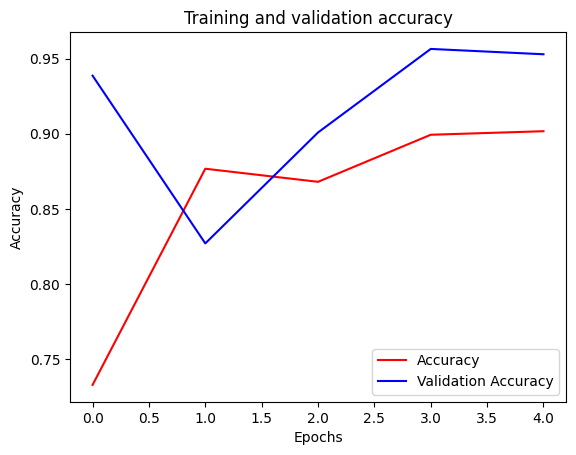

<Figure size 640x480 with 0 Axes>

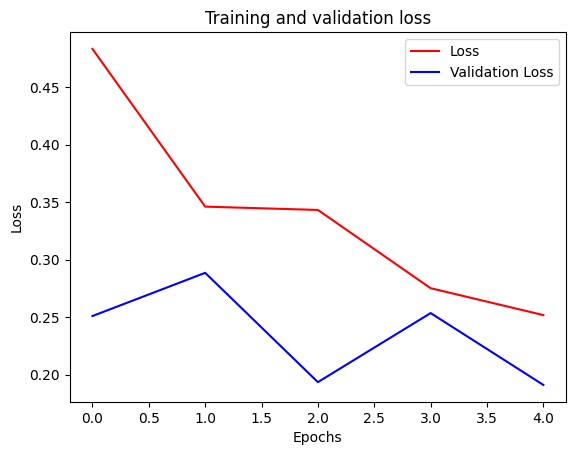

<Figure size 640x480 with 0 Axes>

In [261]:
display_training_curves(history)

## Métriques

In [262]:
# Affichage des métriques
metrics = display_binary_metrics(model, X_test, y_test, 'LSTM')

# Enregistrement des metrics dans le dataframe
metrics_score = pd.concat([metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)

71/71 [==============================] - 4s 50ms/step
Auc: 0.966660692683364 
Matrice de confusion : [[1959   70]
 [  36  184]]
Précision : 0.7244094488188977
Rappel : 0.8363636363636363
Score F1 : 0.7763713080168776


# Bi-LSTM

In [263]:
model = Sequential()
model.add(Embedding(input_dimension, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(300)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 50, 300)           14379900  
                                                                 
 spatial_dropout1d_14 (Spat  (None, 50, 300)           0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_3 (Bidirecti  (None, 600)               1442400   
 onal)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 600)               0         
                                                                 
 batch_normalization_21 (Ba  (None, 600)               2400      
 tchNormalization)                                               
                                                     

In [264]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [265]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    batch_size=batch_size
)
print("Training Complete")

Epoch 1/5


100/100 [==============================] - 17s 161ms/step - loss: 0.4285 - accuracy: 0.7888 - val_loss: 0.3044 - val_accuracy: 0.9302
Epoch 2/5
100/100 [==============================] - 16s 160ms/step - loss: 0.2871 - accuracy: 0.8852 - val_loss: 0.2051 - val_accuracy: 0.9520
Epoch 3/5
100/100 [==============================] - 16s 161ms/step - loss: 0.2545 - accuracy: 0.9018 - val_loss: 0.1759 - val_accuracy: 0.9395
Epoch 4/5
100/100 [==============================] - 16s 157ms/step - loss: 0.2058 - accuracy: 0.9188 - val_loss: 0.1667 - val_accuracy: 0.9426
Epoch 5/5
100/100 [==============================] - 16s 157ms/step - loss: 0.1891 - accuracy: 0.9262 - val_loss: 0.1246 - val_accuracy: 0.9578
Training Complete


## Courbes de Training et Validation

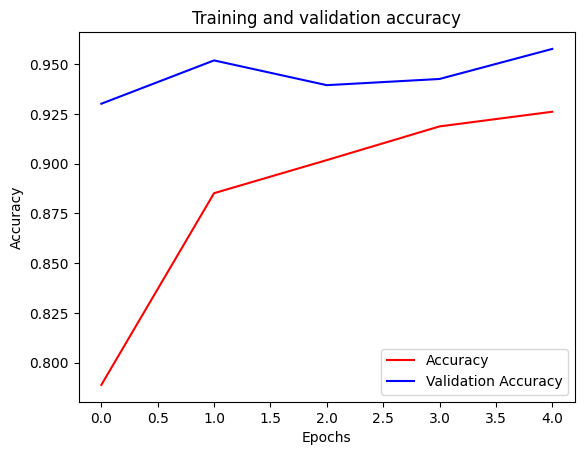

<Figure size 640x480 with 0 Axes>

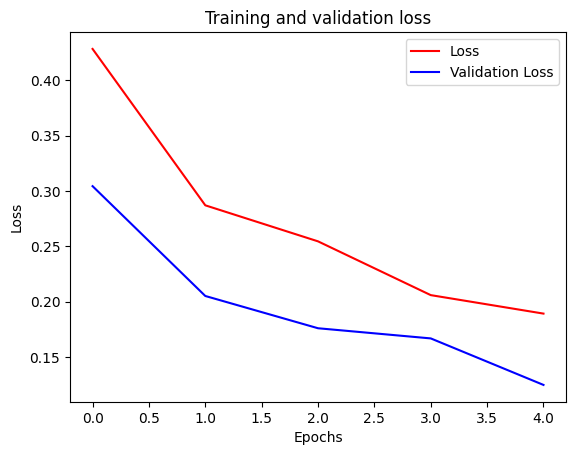

<Figure size 640x480 with 0 Axes>

In [266]:
display_training_curves(history)

## Métriques

In [267]:
# Affichage des métriques
metrics = display_binary_metrics(model, X_test, y_test, 'Bi-LSTM')

# Enregistrement des metrics dans le dataframe
metrics_score = pd.concat([metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)

71/71 [==============================] - 3s 34ms/step
Auc: 0.9722501008109682 
Matrice de confusion : [[1977   52]
 [  43  177]]
Précision : 0.7729257641921398
Rappel : 0.8045454545454546
Score F1 : 0.7884187082405345


# GRU

In [268]:
model = Sequential()
model.add(Embedding(input_dimension, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.3))

model.add(GRU(300))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 50, 300)           14379900  
                                                                 
 spatial_dropout1d_15 (Spat  (None, 50, 300)           0         
 ialDropout1D)                                                   
                                                                 
 gru_5 (GRU)                 (None, 300)               541800    
                                                                 
 dropout_22 (Dropout)        (None, 300)               0         
                                                                 
 batch_normalization_22 (Ba  (None, 300)               1200      
 tchNormalization)                                               
                                                                 
 dense_19 (Dense)            (None, 1)               

In [269]:
filename = 'gru.h5'

# Créez une instance de ModelCheckpoint
checkpoint = ModelCheckpoint(filename,  # chemin du fichier où sauvegarder le modèle
                             monitor='val_loss',  # quelle métrique à surveiller
                             verbose=0, 
                             save_best_only=True,  # ne sauvegarder que le meilleur modèle
                             mode='auto')  # 'auto' signifie que la direction est déterminée automatiquement à partir du nom de la métrique surveillée

history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    batch_size=batch_size,
    callbacks=[checkpoint]
)

print("Training Complete")

# poids fichier de checkpoint
model.load_weights(filename)

Epoch 1/5


100/100 [==============================] - 11s 99ms/step - loss: 0.7178 - accuracy: 0.4429 - val_loss: 0.6791 - val_accuracy: 0.6505
Epoch 2/5
  1/100 [..............................] - ETA: 12s - loss: 0.4707 - accuracy: 0.7344

/Users/antoine/miniconda3/envs/AI_CPU/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 11s 105ms/step - loss: 0.3649 - accuracy: 0.8611 - val_loss: 0.1793 - val_accuracy: 0.9511
Epoch 3/5
100/100 [==============================] - 10s 105ms/step - loss: 0.2637 - accuracy: 0.8989 - val_loss: 0.1349 - val_accuracy: 0.9600
Epoch 4/5
100/100 [==============================] - 10s 100ms/step - loss: 0.2401 - accuracy: 0.9123 - val_loss: 0.1614 - val_accuracy: 0.9480
Epoch 5/5
100/100 [==============================] - 10s 101ms/step - loss: 0.2228 - accuracy: 0.9163 - val_loss: 0.2247 - val_accuracy: 0.9080
Training Complete


## Courbes de Training et Validation

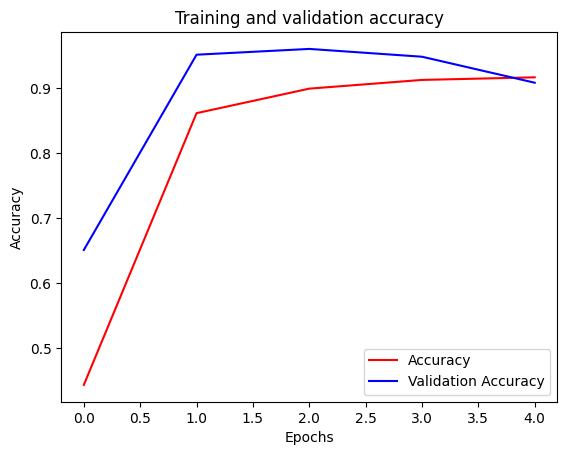

<Figure size 640x480 with 0 Axes>

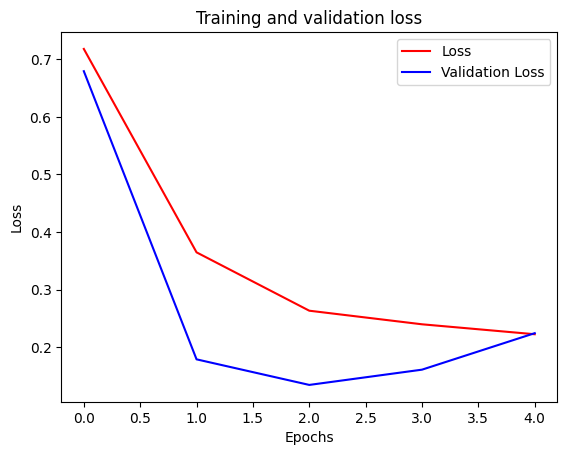

<Figure size 640x480 with 0 Axes>

In [270]:
display_training_curves(history)

## Métriques

In [271]:
# Affichage des métriques
metrics = display_binary_metrics(model, X_test, y_test, 'GRU')

# Enregistrement des metrics dans le dataframe
metrics_score = pd.concat([metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)

71/71 [==============================] - 1s 18ms/step
Auc: 0.9730028227071106 
Matrice de confusion : [[1985   44]
 [  46  174]]
Précision : 0.7981651376146789
Rappel : 0.7909090909090909
Score F1 : 0.7945205479452055


# GRU + Attention

In [272]:
from tensorflow.keras.layers import SpatialDropout1D, GRU, Dropout, BatchNormalization, Dense, Embedding
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from keras import backend as K
import tensorflow as tf



# Input Layer
input_layer = Input(shape=(max_length,))

# Embedding Layer
embedding_layer = Embedding(input_dimension, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)
spatial_dropout = SpatialDropout1D(0.3)(embedding_layer)

# GRU Layer
gru_layer = GRU(300, return_sequences=True)(spatial_dropout)
dropout_layer_2 = Dropout(0.5)(gru_layer)
batch_norm_layer_2 = BatchNormalization()(dropout_layer_2)

# Attention Layer
attention_layer = Attention()([batch_norm_layer_2, batch_norm_layer_2])
dropout_layer_3 = Dropout(0.5)(attention_layer)
batch_norm_layer_3 = BatchNormalization()(dropout_layer_3)

# Flatten Layer
flatten_layer = Flatten()(attention_layer)

# Dense Layers
dense_layer_1 = Dense(32, activation='relu')(flatten_layer)
dropout_layer_1 = Dropout(0.5)(dense_layer_1)
batch_norm_layer_1 = BatchNormalization()(dropout_layer_1)

dense_layer_2 = Dense(16, activation='relu')(batch_norm_layer_1)
dropout_layer_4 = Dropout(0.5)(dense_layer_2)
batch_norm_layer_4 = BatchNormalization()(dropout_layer_4)

output_layer = Dense(1, activation='sigmoid')(batch_norm_layer_4)

# Compile model
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 50, 300)              1437990   ['input_4[0][0]']             
                                                          0                                       
                                                                                                  
 spatial_dropout1d_16 (Spat  (None, 50, 300)              0         ['embedding_16[0][0]']        
 ialDropout1D)                                                                                    
                                                                                            

In [273]:

filename = 'attention.h5'

# Créez une instance de ModelCheckpoint
checkpoint = ModelCheckpoint(filename,  # chemin du fichier où sauvegarder le modèle
                             monitor='val_loss',  # quelle métrique à surveiller
                             verbose=0, 
                             save_best_only=True,  # ne sauvegarder que le meilleur modèle
                             mode='auto')  # 'auto' signifie que la direction est déterminée automatiquement à partir du nom de la métrique surveillée

history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    batch_size=batch_size,
    callbacks=[checkpoint]
)


print("Training Complete")

# poids fichier de checkpoint
model.load_weights(filename)

Epoch 1/5


W0000 00:00:1710514536.934769       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 12 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


100/100 [==============================] - ETA: 0s - loss: 0.5821 - accuracy: 0.6699

W0000 00:00:1710514548.664011       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 12 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


100/100 [==============================] - 13s 125ms/step - loss: 0.5821 - accuracy: 0.6699 - val_loss: 0.4115 - val_accuracy: 0.9320
Epoch 2/5


/Users/antoine/miniconda3/envs/AI_CPU/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 14s 141ms/step - loss: 0.3934 - accuracy: 0.8560 - val_loss: 0.3170 - val_accuracy: 0.9346
Epoch 3/5
100/100 [==============================] - 13s 131ms/step - loss: 0.3206 - accuracy: 0.8984 - val_loss: 0.2936 - val_accuracy: 0.9213
Epoch 4/5
100/100 [==============================] - 15s 149ms/step - loss: 0.2942 - accuracy: 0.9170 - val_loss: 0.1387 - val_accuracy: 0.9604
Epoch 5/5
100/100 [==============================] - 14s 137ms/step - loss: 0.2803 - accuracy: 0.9218 - val_loss: 0.1470 - val_accuracy: 0.9582
Training Complete


## Courbes de Training et Validation

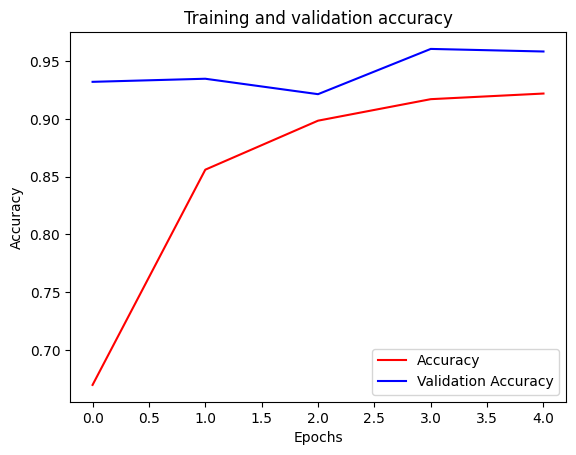

<Figure size 640x480 with 0 Axes>

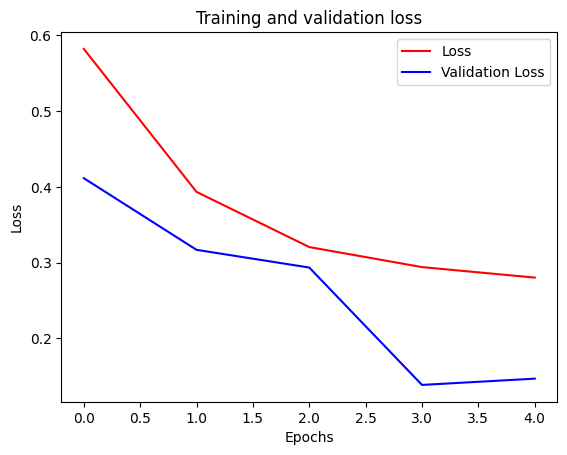

<Figure size 640x480 with 0 Axes>

In [274]:
display_training_curves(history)

## Métriques

In [275]:
# Affichage des métriques
metrics = display_binary_metrics(model, X_test, y_test, 'Attention')

# Enregistrement des metrics dans le dataframe
metrics_score = pd.concat([metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)

 5/71 [=>............................] - ETA: 1s

W0000 00:00:1710514605.907862       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 12 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


71/71 [==============================] - 2s 27ms/step
Auc: 0.9701801155965769 
Matrice de confusion : [[1978   51]
 [  38  182]]
Précision : 0.7811158798283262
Rappel : 0.8272727272727273
Score F1 : 0.8035320088300221


## Comparaison des modèles 

Nous observons la moyenne entre 2 métriques : la ROC_AUC et le F1_score.

Chacun des deux ont des points forts et des points faibles donc on choisit de prendre en compte la moyenne entre les deux.


In [276]:
# mean between roc_auc and f1_score
metrics_score['mean'] = metrics_score[['roc_auc', 'f1_score']].mean(axis=1)



On remarque que le GRU et le Bi-LSTM sont performants.

Bizarrement, le GRU ameilioré avec un Attention ne semble pas être aussi efficaces que prévu.

In [277]:
# display metrics in order from best to worst by mean
metrics_score.sort_values(by=['mean'], ascending=False)

,model,roc_auc,confusion_matrix,precision_score,recall_score,f1_score,mean
6,Attention,0.970180,"[[1978, 51], [38, 182]]",0.781116,0.827273,0.803532,0.886856
5,GRU,0.973003,"[[1985, 44], [46, 174]]",0.798165,0.790909,0.794521,0.883762
4,Bi-LSTM,0.972250,"[[1977, 52], [43, 177]]",0.772926,0.804545,0.788419,0.880334
3,LSTM,0.966661,"[[1959, 70], [36, 184]]",0.724409,0.836364,0.776371,0.871516
0,RandomForestClassifier,0.682489,"[[1987, 15], [155, 92]]",0.859813,0.372470,0.519774,0.601131
2,RNN,0.772461,"[[1009, 1020], [32, 188]]",0.155629,0.854545,0.263305,0.517883
1,RNN (No GloVe),0.641979,"[[2024, 5], [218, 2]]",0.285714,0.009091,0.017621,0.329800


# Recurrent Neural Network en Multilabel Classification

In [278]:
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'isToxic']]

# Split les sequences 
on divise le jeu de donnée en données d'entrainement et de validation

In [279]:
test_portion=.15

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=test_portion)

# Sample Weight

le problème dans un cas de classification multilabel c'est qu'il va essayer d'equilibrer les données en fonction de toutes les combinaisons, car dans notre cas, chaque combinaison devient une classe a part entière.

Nous avons donc fait le choix de donner en parametre de compute_sample_weight, la classification binaire des données (Toxique / Non toxique) et d'eventuellement donner plus de poids aux données toxiques.


In [280]:
# Si y_train est en mode multiclasse, nous devons recuperer le labels en mode binaire
y_train_isToxic = y_train['isToxic']
y_test_isToxic = y_test['isToxic']

# Enlever la colonnes contenant les labels en mode binaire
y_train = y_train.drop(columns=['isToxic'])
y_test = y_test.drop(columns=['isToxic'])

In [281]:
from sklearn.utils import compute_sample_weight

# recuperer les poids des classes de manière équilibrée en fonction des classes presentes dans y_train
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_isToxic)

# augmentation des poids des commentaires toxiques
# sample_weights[y_train_isToxic == 1] *= 1.5

# Bi-LSTM

In [282]:
model = Sequential()
model.add(Embedding(input_dimension, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(300)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(6, activation='sigmoid')) 

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 50, 300)           14379900  
                                                                 
 spatial_dropout1d_17 (Spat  (None, 50, 300)           0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_4 (Bidirecti  (None, 600)               1442400   
 onal)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 600)               0         
                                                                 
 batch_normalization_27 (Ba  (None, 600)               2400      
 tchNormalization)                                               
                                                     

In [283]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [284]:
filename = 'Bi-LSTM-multi.h5'

# Créez une instance de ModelCheckpoint
checkpoint = ModelCheckpoint(filename,  # chemin du fichier où sauvegarder le modèle
                             monitor='val_loss',  # quelle métrique à surveiller
                             verbose=0, 
                             save_best_only=True,  # ne sauvegarder que le meilleur modèle
                             mode='auto')  # 'auto' signifie que la direction est déterminée automatiquement à partir du nom de la métrique surveillée

history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    batch_size=batch_size,
    callbacks=[checkpoint]
)

print("Training Complete")

# poids fichier de checkpoint
model.load_weights(filename)

Epoch 1/5


100/100 [==============================] - 18s 166ms/step - loss: 0.5277 - accuracy: 0.3103 - val_loss: 0.2524 - val_accuracy: 0.4366
Epoch 2/5


/Users/antoine/miniconda3/envs/AI_CPU/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 16s 159ms/step - loss: 0.2521 - accuracy: 0.4998 - val_loss: 0.1057 - val_accuracy: 0.8791
Epoch 3/5
100/100 [==============================] - 17s 169ms/step - loss: 0.1982 - accuracy: 0.5829 - val_loss: 0.0713 - val_accuracy: 0.8106
Epoch 4/5
100/100 [==============================] - 16s 162ms/step - loss: 0.1800 - accuracy: 0.6271 - val_loss: 0.0772 - val_accuracy: 0.8808
Epoch 5/5
100/100 [==============================] - 16s 161ms/step - loss: 0.1593 - accuracy: 0.6543 - val_loss: 0.0706 - val_accuracy: 0.8208
Training Complete


## Courbes de Training et Validation

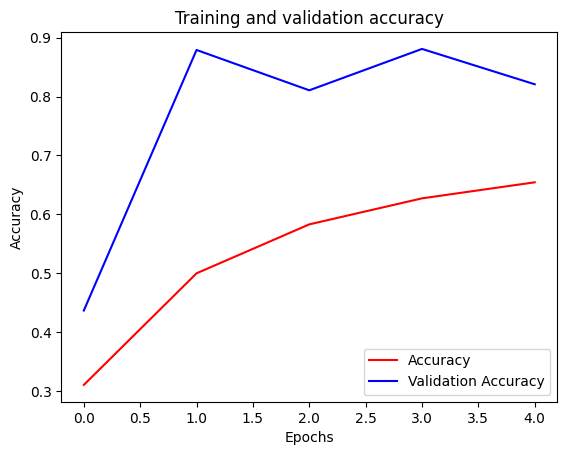

<Figure size 640x480 with 0 Axes>

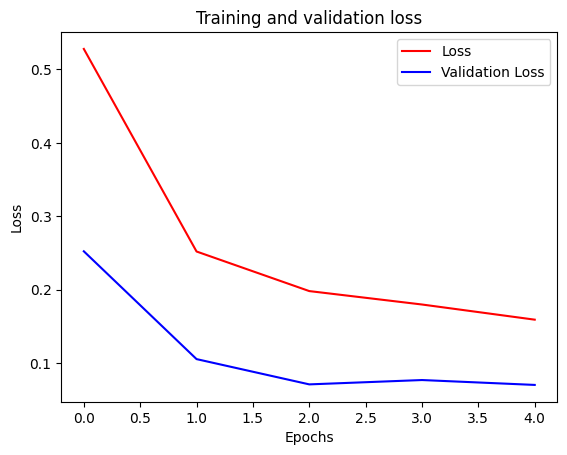

<Figure size 640x480 with 0 Axes>

In [285]:
display_training_curves(history)

## Métriques

In [286]:
multi_metrics_score = pd.DataFrame(columns=['model', 'roc_auc', 'precision_score', 'recall_score', 'f1_score'])

On va prendre le roc_auc pour chaque categories et en faire la moyenne

In [287]:
import statistics


def roc_auc_multilabel(y_pred, y_true):
    # Calculer l'AUC-ROC pour chaque classe

    y_pred_df = pd.DataFrame(y_pred, columns=categories)
    y_true_df = pd.DataFrame(y_true, columns=categories)

    roc_auc_list = []

    for i in range(len(categories)):
        y_true_cat = y_true_df[categories[i]]
        y_pred_cat = y_pred_df[categories[i]]
        roc_auc_list.append(roc_auc(y_pred_cat, y_true_cat))

    return statistics.mean(roc_auc_list)


In [288]:

def display_multi_metrics(model, X_test, y_test, name):
    # prédictions et vraies valeurs
    y_pred = model.predict(X_test)
    y_true = y_test

    # Affichage de l'aire sous la courbe ROC
    roc = roc_auc_multilabel(y_pred, y_true)
    print(f"Auc: {roc} ")

    # Arrondir les prédictions
    y_pred = y_pred.round()

    # Affichage de la précision
    precision = precision_score(y_true, y_pred, average='weighted')
    print(f"Précision : {precision}")

    # Affichage du rappel
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"Rappel : {recall}")

    # Affichage du score F1
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Score F1 : {f1}")

    return {
        'model': name,
        'roc_auc': roc,
        'precision_score': precision,
        'recall_score': recall,
        'f1_score': f1
    }




In [289]:
# Affichage des métriques
metrics = display_multi_metrics(model, X_test, y_test, 'Bi-LSTM')

# Enregistrement des metrics dans le dataframe
multi_metrics_score = pd.concat([multi_metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)

71/71 [==============================] - 3s 34ms/step
Auc: 0.9119186389633328 
Précision : 0.6621918457765447
Rappel : 0.6883910386965377
Score F1 : 0.6493709334374221


/Users/antoine/miniconda3/envs/AI_CPU/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/4h/0hgx3df95ll34vbrssxhzfvm0000gn/T/ipykernel_1135/77155544.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  multi_metrics_score = pd.concat([multi_metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)


# GRU

In [290]:
model = Sequential()
model.add(Embedding(input_dimension, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.3))

model.add(GRU(300))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())

model.add(Dense(6, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 50, 300)           14379900  
                                                                 
 spatial_dropout1d_18 (Spat  (None, 50, 300)           0         
 ialDropout1D)                                                   
                                                                 
 gru_7 (GRU)                 (None, 300)               541800    
                                                                 
 dropout_28 (Dropout)        (None, 300)               0         
                                                                 
 batch_normalization_28 (Ba  (None, 300)               1200      
 tchNormalization)                                               
                                                                 
 dense_24 (Dense)            (None, 6)               

In [291]:
filename = 'gru-multi.h5'

# Créez une instance de ModelCheckpoint
checkpoint = ModelCheckpoint(filename,  # chemin du fichier où sauvegarder le modèle
                             monitor='val_loss',  # quelle métrique à surveiller
                             verbose=0, 
                             save_best_only=True,  # ne sauvegarder que le meilleur modèle
                             mode='auto')  # 'auto' signifie que la direction est déterminée automatiquement à partir du nom de la métrique surveillée

history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    batch_size=batch_size,
    callbacks=[checkpoint]
)

print("Training Complete")

# poids fichier de checkpoint
model.load_weights(filename)

Epoch 1/5
100/100 [==============================] - 11s 107ms/step - loss: 0.6218 - accuracy: 0.6511 - val_loss: 0.3475 - val_accuracy: 0.7399
Epoch 2/5
  1/100 [..............................] - ETA: 13s - loss: 0.4830 - accuracy: 0.7578

/Users/antoine/miniconda3/envs/AI_CPU/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 11s 112ms/step - loss: 0.3607 - accuracy: 0.7220 - val_loss: 0.1775 - val_accuracy: 0.9858
Epoch 3/5
100/100 [==============================] - 11s 108ms/step - loss: 0.2548 - accuracy: 0.7654 - val_loss: 0.1089 - val_accuracy: 0.8768
Epoch 4/5
100/100 [==============================] - 10s 103ms/step - loss: 0.2220 - accuracy: 0.8059 - val_loss: 0.0819 - val_accuracy: 0.8688
Epoch 5/5
100/100 [==============================] - 11s 109ms/step - loss: 0.2062 - accuracy: 0.8102 - val_loss: 0.1807 - val_accuracy: 0.9689
Training Complete


## Courbes de Training et Validation

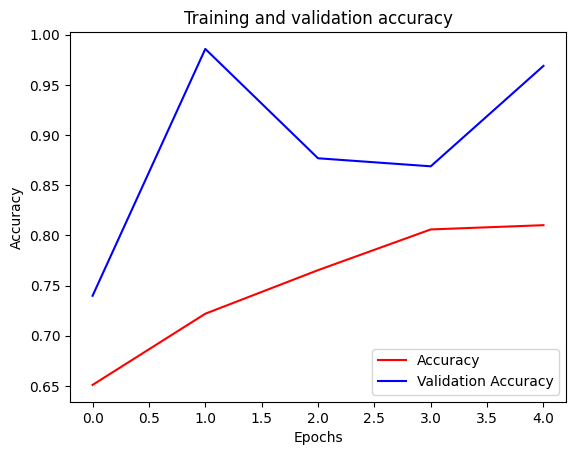

<Figure size 640x480 with 0 Axes>

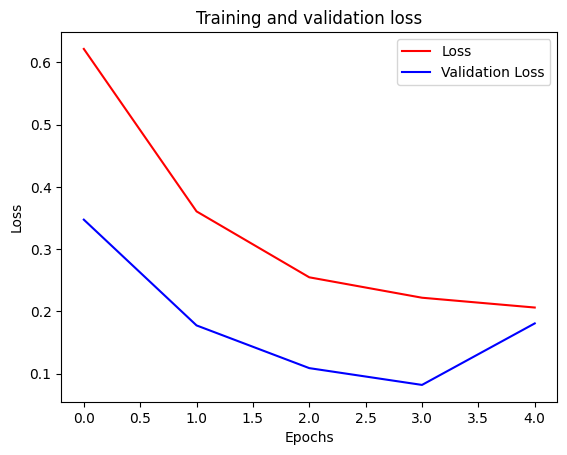

<Figure size 640x480 with 0 Axes>

In [292]:
display_training_curves(history)

## Métriques

In [293]:
# Affichage des métriques
metrics = display_multi_metrics(model, X_test, y_test, 'GRU')

# Enregistrement des metrics dans le dataframe
multi_metrics_score = pd.concat([multi_metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)

71/71 [==============================] - 2s 23ms/step
Auc: 0.9362411505173129 
Précision : 0.6978125823280086
Rappel : 0.6415478615071283
Score F1 : 0.6473598227816334


/Users/antoine/miniconda3/envs/AI_CPU/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Attention + GRU

In [296]:
from tensorflow.keras.layers import SpatialDropout1D, GRU, Dropout, BatchNormalization, Dense, Embedding
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from keras import backend as K
import tensorflow as tf



# Input Layer
input_layer = Input(shape=(max_length,))

# Embedding Layer
embedding_layer = Embedding(input_dimension, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)
spatial_dropout = SpatialDropout1D(0.3)(embedding_layer)

# GRU Layer
gru_layer = GRU(300, return_sequences=True)(spatial_dropout)
dropout_layer_2 = Dropout(0.5)(gru_layer)
batch_norm_layer_2 = BatchNormalization()(dropout_layer_2)

# Attention Layer
attention_layer = Attention()([batch_norm_layer_2, batch_norm_layer_2])
dropout_layer_3 = Dropout(0.5)(attention_layer)
batch_norm_layer_3 = BatchNormalization()(dropout_layer_3)

# Flatten Layer
flatten_layer = Flatten()(attention_layer)

# Dense Layers
dense_layer_1 = Dense(32, activation='relu')(flatten_layer)
dropout_layer_1 = Dropout(0.5)(dense_layer_1)
batch_norm_layer_1 = BatchNormalization()(dropout_layer_1)

dense_layer_2 = Dense(16, activation='relu')(batch_norm_layer_1)
dropout_layer_4 = Dropout(0.5)(dense_layer_2)
batch_norm_layer_4 = BatchNormalization()(dropout_layer_4)

output_layer = Dense(6, activation='sigmoid')(batch_norm_layer_4)

# Compile model
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_19 (Embedding)    (None, 50, 300)              1437990   ['input_5[0][0]']             
                                                          0                                       
                                                                                                  
 spatial_dropout1d_19 (Spat  (None, 50, 300)              0         ['embedding_19[0][0]']        
 ialDropout1D)                                                                                    
                                                                                            

In [297]:
filename = 'attention-multi.h5'

# Créez une instance de ModelCheckpoint
checkpoint = ModelCheckpoint(filename,  # chemin du fichier où sauvegarder le modèle
                             monitor='val_loss',  # quelle métrique à surveiller
                             verbose=0, 
                             save_best_only=True,  # ne sauvegarder que le meilleur modèle
                             mode='auto')  # 'auto' signifie que la direction est déterminée automatiquement à partir du nom de la métrique surveillée

history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    batch_size=batch_size,
    callbacks=[checkpoint]
)

print("Training Complete")

# poids fichier de checkpoint
model.load_weights(filename)

Epoch 1/5


W0000 00:00:1710515752.843084       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 12 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


100/100 [==============================] - ETA: 0s - loss: 0.7232 - accuracy: 0.2905

W0000 00:00:1710515766.156647       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 12 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


100/100 [==============================] - 15s 141ms/step - loss: 0.7232 - accuracy: 0.2905 - val_loss: 0.6071 - val_accuracy: 0.6376
Epoch 2/5


/Users/antoine/miniconda3/envs/AI_CPU/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 14s 144ms/step - loss: 0.5874 - accuracy: 0.5014 - val_loss: 0.5133 - val_accuracy: 0.9213
Epoch 3/5
100/100 [==============================] - 14s 145ms/step - loss: 0.4762 - accuracy: 0.5740 - val_loss: 0.3538 - val_accuracy: 0.6496
Epoch 4/5
100/100 [==============================] - 15s 147ms/step - loss: 0.3924 - accuracy: 0.6345 - val_loss: 0.2070 - val_accuracy: 0.4335
Epoch 5/5
100/100 [==============================] - 14s 144ms/step - loss: 0.3428 - accuracy: 0.6710 - val_loss: 0.1546 - val_accuracy: 0.6309
Training Complete


## Courbes de Training et Validation

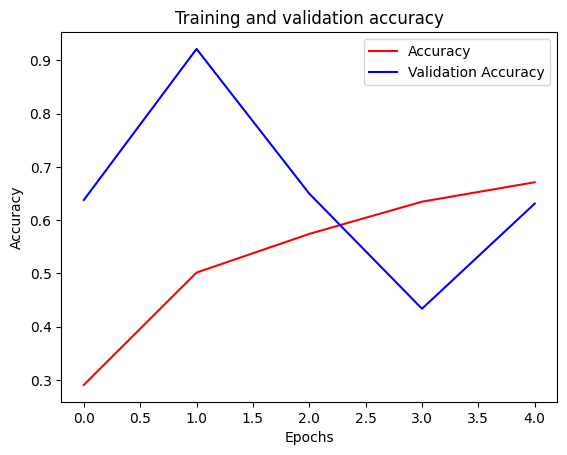

<Figure size 640x480 with 0 Axes>

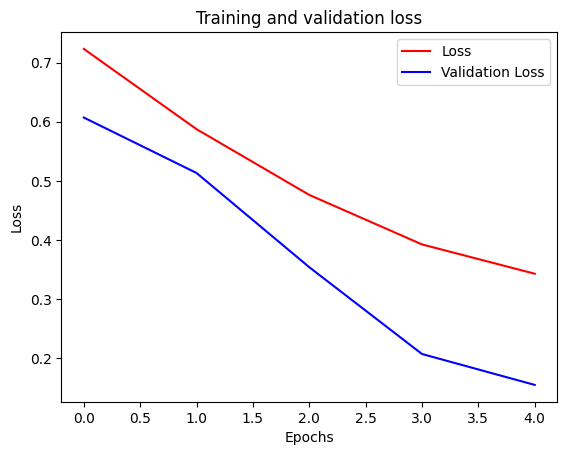

<Figure size 640x480 with 0 Axes>

In [298]:
display_training_curves(history)

## Métriques

In [301]:
# Affichage des métriques
metrics = display_multi_metrics(model, X_test, y_test, 'Attention')

# Enregistrement des metrics dans le dataframe
multi_metrics_score = pd.concat([multi_metrics_score, pd.DataFrame.from_dict([metrics])], ignore_index=True)

71/71 [==============================] - 2s 27ms/step
Auc: 0.738123874678648 
Précision : 0.2502231956030466
Rappel : 0.3564154786150713
Score F1 : 0.2940248415134391


/Users/antoine/miniconda3/envs/AI_CPU/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Comparaison des modèles

On remarque que le GRU est le modele le plus performant

In [302]:
# mean between roc_auc and f1_score
multi_metrics_score['mean'] = multi_metrics_score[['roc_auc', 'f1_score']].mean(axis=1)

# display metrics in order from best to worst by mean
multi_metrics_score.sort_values(by=['mean'], ascending=False)


,model,roc_auc,precision_score,recall_score,f1_score,mean
1,GRU,0.936241,0.697813,0.641548,0.647360,0.791800
0,Bi-LSTM,0.911919,0.662192,0.688391,0.649371,0.780645
2,GRU,0.738124,0.250223,0.356415,0.294025,0.516074
3,Attention,0.738124,0.250223,0.356415,0.294025,0.516074


In [303]:
metrics_score.sort_values(by=['mean'], ascending=False)

,model,roc_auc,confusion_matrix,precision_score,recall_score,f1_score,mean
6,Attention,0.970180,"[[1978, 51], [38, 182]]",0.781116,0.827273,0.803532,0.886856
5,GRU,0.973003,"[[1985, 44], [46, 174]]",0.798165,0.790909,0.794521,0.883762
4,Bi-LSTM,0.972250,"[[1977, 52], [43, 177]]",0.772926,0.804545,0.788419,0.880334
3,LSTM,0.966661,"[[1959, 70], [36, 184]]",0.724409,0.836364,0.776371,0.871516
0,RandomForestClassifier,0.682489,"[[1987, 15], [155, 92]]",0.859813,0.372470,0.519774,0.601131
2,RNN,0.772461,"[[1009, 1020], [32, 188]]",0.155629,0.854545,0.263305,0.517883
1,RNN (No GloVe),0.641979,"[[2024, 5], [218, 2]]",0.285714,0.009091,0.017621,0.329800


# BERT